# Satellite Acquisition

**BEFORE RUNNING THIS CODE: **Download the launch 12 GPS data [here](https://github.com/psas/Launch-12/blob/gh-pages/data/GPS/JGPS%40-32.041913222), and place it in the */resources* folder.

This notebook demonstrates the satellite acquisition proccess, in which we determine which satellites are overhead. This code implements the parallel code phase search algorithm, which is the most complex of those available, but is also the fastest since it returns a result in just one iteration. It is possible that we will need to use a different algorithm when the code is running on an embedded platform.

As noted in the L-12 GPS data README, the sampling frequency is 4.092 MHz. and the IF is 0. Also note that the L1 signal hits the antenna at the 1.57542 GHz frequency (10.23 MHz x 154). This is dealt with by the hardware frontend, so we only have to concern ourselves with the 1.023 MHz BPSK modulated C/A code.

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math
import heapq

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

## Import data File

- Information on file "JGPS@04.559925043" can be found at: https://github.com/psas/Launch-12/tree/gh-pages/data/GPS

In [2]:
# Need these to pass to importFile module
fs = 4.092*10**6 # Sampling Frequency [Hz]
NumberOfMilliseconds = 5
#SampleLength = NumberOfMilliseconds*10**(-3) # Sample length in 1ms multiples
SampleLength = NumberOfMilliseconds*10**(-3)
BytesToSkip = 0

data = IQData()

# Uncomment one of these lines to choose between Launch12 or gps-sdr-sim data
#data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)
data.importFile('../resources/test.max', fs, SampleLength, BytesToSkip)

BinWidth = (fs/len(data.CData))
print("BinWidth is: %f [Hz]"%(BinWidth))

Opening a file.
File handle is: 49.
Total Samples to read: 20460
Total Bytes read: 10230.
Which equals 20460 IQ pairs.
Sample Length: 0.005000 seconds.
File is now closed.
BinWidth is: 200.000000 [Hz]


# LO Sweep

- Between these 2 steps we need to sweep the local oscillator due to Doppler effect
- Pick a frequency, and run the steps from here assuming the Doppler shift puts us @ that freq
- We need to multiply the incoming data by a complex sine wave 
- The frequency of the generated wave is equal to the difference between the actual and target frequencies
- The sine wave must be complex in order to get a negative frequency (sweep both directions)
- Book recommends +/- 10kHz in 500Hz steps (pg 77)

## Check out the imported data

We will plot the first 100 samples to see what the signal looks like.

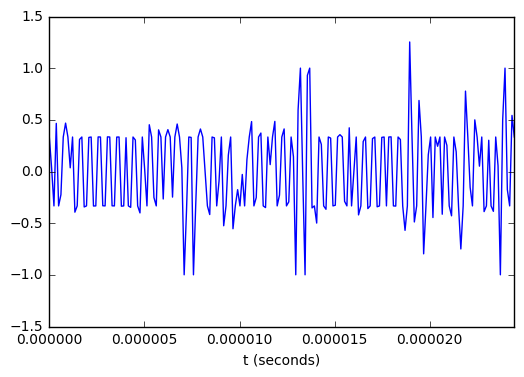

In [3]:
# Convert to real data
tReal, RData = data.ComplexToReal(data.CData)

plt.plot(tReal, RData)

# Set xaxis so first 100 samples are shown
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 100/(fs))

plt.xlabel("t (seconds)")
plt.show()

# View Complex Data Spectrum

We need to take the fft of the IQ datastream.

In [4]:
# Since we are using circular-convolution, nfft must be equal to the number of samples
nfft = data.Nsamples
deltaFreq = fs/nfft
print("Calculated deltaFreq: %f [Hz]" %(deltaFreq))

# Generate frequency lists for plotting fft
# Can use f for regular fft and fshift for shifted version
fs_kHz = fs/1000 #Make easier to read
f = np.linspace (0,fs_kHz,nfft, endpoint=False)
fshift = np.linspace(-fs_kHz/2,fs_kHz/2,nfft,endpoint=False)


# Reference data size section of book to pick the len param. Should be based sample rate
ffC = np.fft.fft(data.CData, nfft)

Calculated deltaFreq: 200.000000 [Hz]


# Plot output

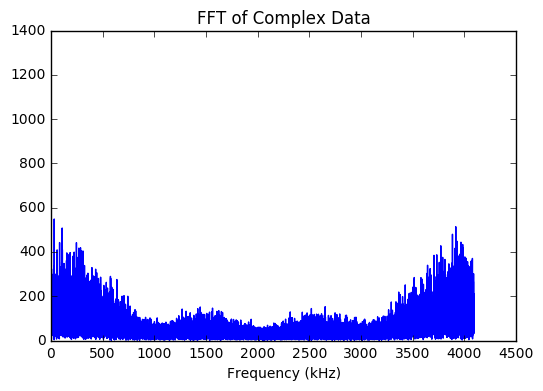

In [5]:
plt.plot(f, np.abs(ffC))

plt.title("FFT of Complex Data")
plt.xlabel("Frequency (kHz)")
#plt.ylim((0,400))
plt.show()

# Get a Gold Code

- Gold Code must be generated as though it were sampled at the sampling rate
- 1023 chips that must take 1ms to pass through (due to chipping rate)
- We are sampling @ 4.092 MHz
- So we need the GC to repeat each chip 4 times before going to the next chip.
- The numpy.repeat() function does this exactly

## SVs in this data:

#SV| Doppler(Hz)| Alt (deg)| Az (deg)
---|------------|----------|--------
13 |     3195   | 23.3| 216.5
11 |     3097   |  5.8|  39.0
28 |     1581   | 43.4|  76.3
17 |      359   | 80.6|  80.1
12 |    -2825   |  5.6| 277.7
15 |     1994   | 25.7| 255.4
01 |     1797   | 19.3|  44.4
24 |    -2592   | 31.9| 309.6
30 |     3378   | 13.4| 141.2
06 |    -3321   | 21.1| 159.8

In [6]:
#code = np.repeat(CodeGen.getCode(1023), 4)

#Choose which satellite's C/A code is generated
Satellite = 15

# Create list of C/A code Taps, for simpler sat selection",
#sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

# Create Code Generator object for chosen Satellite
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

# Generate CA Code
CACode = CodeGen.getCode(1023)

# Reformat GC to have -1 in place of 0 (Now done in GoldCode)
#for n,i in enumerate(CACode):
#    if i==0:
#        CACode[n]=-1
        
# Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
CACodeSampled = np.repeat(CACode,4)
print("Satellite chosen: %d, with tap: %s" %(Satellite,str(sat[Satellite - 1])))

# Repeat entire array for each ms of data sampled
CACodeSampled = np.tile(CACodeSampled,int(SampleLength*1000))
print(len(CACodeSampled))

Satellite chosen: 15, with tap: (7, 8)
20460


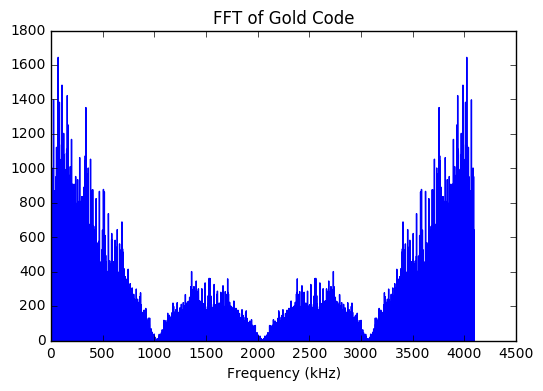

In [7]:
Codefft = np.fft.fft(CACodeSampled, nfft)

plt.plot(f, np.abs(Codefft))
plt.title("FFT of Gold Code")
plt.xlabel("Frequency (kHz)")
plt.show()

## Function to find second largest value

In [8]:
# This will return second largest value
# It will also ignore any value that is close to the second largest value
def GetSecondLargest(DataList):
    # Make sure is a numpy array
    DataArray = np.array(DataList)
    
    # Find largest value
    Largest = np.amax(DataArray)
    LargestIndex = np.argmax(DataArray)
    #print("Largest value: %f, at position: %d"%(Largest,LargestIndex))
    
    # Reduce value by a percent to prevent near-identical values from being selected
    ScaleAmount = 0.95
    ScaledLargest = ScaleAmount*Largest
    SecondLargest = 0
    SecondLargestIndex = 0
    
    for ind,val in enumerate(DataArray):
        if val < ScaledLargest:
            if val > SecondLargest:
                #Ignore adjacent bins to Largest
                if (np.abs(LargestIndex-ind) > 100):
                    SecondLargest = val
                    SecondLargestIndex = ind
    
    #print("Second largest value: %f, at position: %d"%(SecondLargest,SecondLargestIndex))
    return SecondLargest

# Complex Conjugate of Gold Code fft

Take the complex conjugate of the Gold Code [real(fft) - imag(fft)j], and then multiply it by the IQ fft. If this is done correctly there should be a spike about $10^7$ times as high as the noise. 



Length of t: 20460
Length of IFFT: 20460


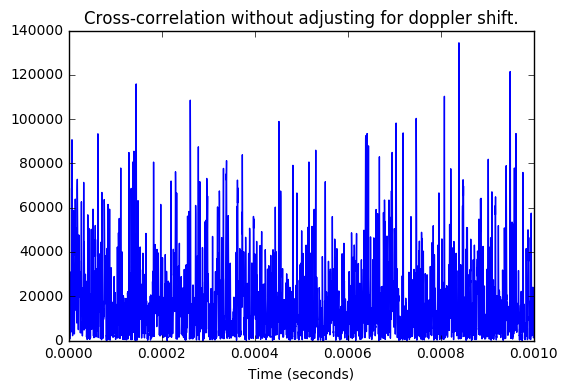

SNR: 0.440413
Max Value: 134425.777778, at freqshift: 0, with index 3433


In [9]:
GCConj = np.conjugate(Codefft)

result = np.fft.ifft(GCConj * ffC,nfft)

resultSQ = np.real(result*np.conjugate(result))

t = np.linspace(0,SampleLength,nfft,endpoint=True) 
print("Length of t: %d" %(len(t)))
print("Length of IFFT: %d" %(len(resultSQ)))

plt.plot(t,resultSQ)

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)

plt.title("Cross-correlation without adjusting for doppler shift.")
plt.xlabel("Time (seconds)")
plt.show()

# Search for largest value in 1 ms worth of data
SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index %d"%(np.amax(resultSQ),0,np.argmax(resultSQ)))

# Notes

- From book appendix: we should look for the top 2 peaks, and use the ratio to determine whether there is a signal or just noise
- We should get the C code running and be sure to compare results. Acquisition works in the C code, but tracking is untested

## Shift frequency using multiplication by a complex exponential

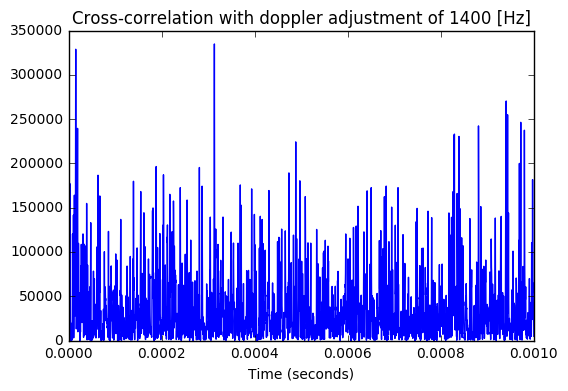

SNR: 0.927719
Max Value: 334780.402414, at freqshift: 1400, with index: 5373


In [10]:
freqShift = 1400 #[Hz] -20


# Initialize complex array
CDataShifted = data.CData*np.exp(1j*2*np.pi*freqShift*data.t)
fftCDataShifted = np.fft.fft(CDataShifted,nfft)

result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
resultSQ = np.real(result*np.conjugate(result))
resultLog = 10*np.log10(resultSQ)

plt.plot(t,resultSQ)
plt.title("Cross-correlation with doppler adjustment of %d [Hz]"%(freqShift))
plt.xlabel("Time (seconds)")

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)
plt.show()

# Search for largest value in 1 ms worth of data
SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index: %d"%(np.amax(resultSQ),freqShift,np.argmax(resultSQ)))

##### Shift frequency by rotating FFT array

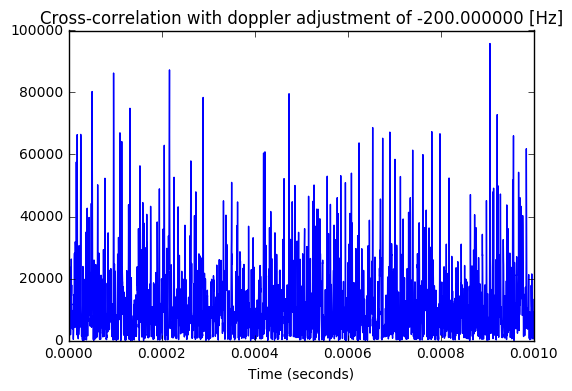

SNR: 0.403816
Max Value: 95791.087807, at freqshift: 1400, with index: 7798


In [11]:
freqRoll = -1 #[Bin number (See BinWidth for frequency resolution)]

# Initialize complex array
fftCDataShifted = np.roll(np.fft.fft(data.CData,nfft),freqRoll)

result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
resultSQ = np.real(result*np.conjugate(result))
resultLog = 20*np.log10(np.abs(result))

plt.plot(t,resultSQ)
plt.title("Cross-correlation with doppler adjustment of %f [Hz]"%(freqRoll*BinWidth))
plt.xlabel("Time (seconds)")

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)
plt.show()

# Search for largest value in 1 ms worth of data
SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index: %d"%(np.amax(resultSQ),freqShift,np.argmax(resultSQ)))

## Multiply original signal by shifted Gold Code

20460
20460


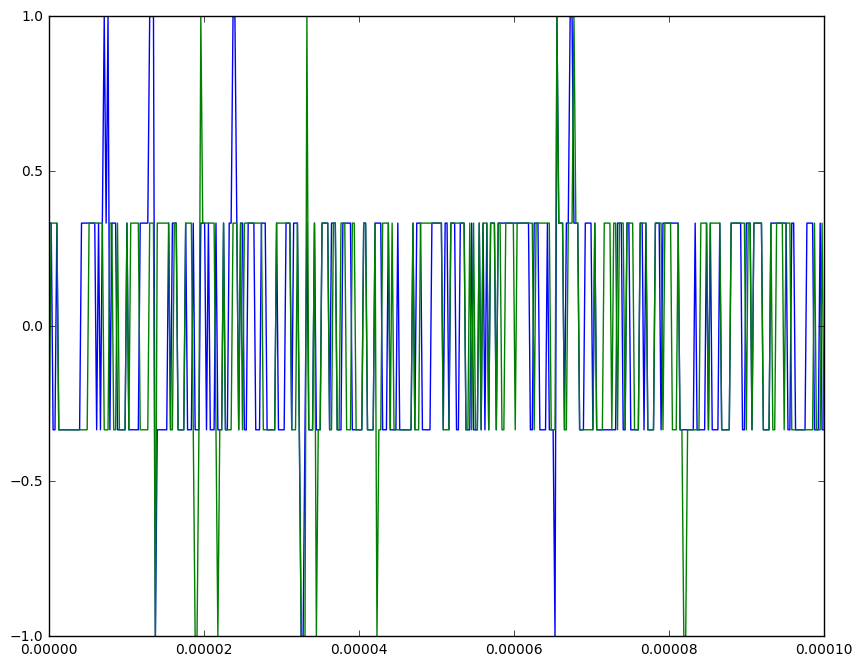

In [12]:
#      NEEDS some modifications

# Shift gold code by maximum index from prior cell
CACode_Shifted = CACodeSampled
np.roll(CACode_Shifted,np.argmax(resultLog))

print(len(data.CData))
print(len(CACode_Shifted))
# Multiply by frequency shifted complex data: 
Result = CACode_Shifted*data.CData

plt.figure(figsize=(10,8))
plt.plot(t,np.real(Result))
plt.plot(t, np.imag(Result))
plt.xlim(0,0.0001)
plt.show()

## Shift through frequency and satellite range

Sat: 1, Freq: -3500.0000, PeakToMean:  16.0759, PeakToSecond:   6.1957, Phase (chips): 630.0000
Sat: 1, Freq: -3300.0000, PeakToMean:  17.9857, PeakToSecond:   8.8943, Phase (chips): 630.0000
Sat: 1, Freq: -3200.0000, PeakToMean:  20.3054, PeakToSecond:  11.2951, Phase (chips): 630.0000


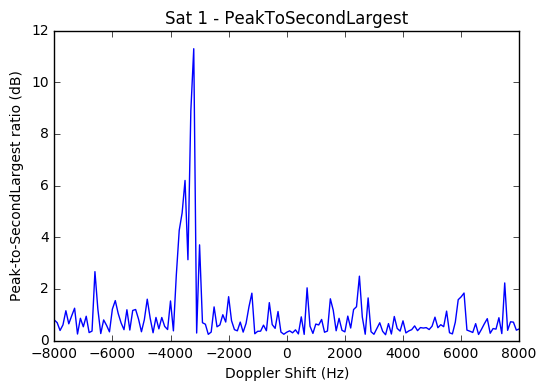

Sat: 1. Frequency with highest peak: -3200.000000


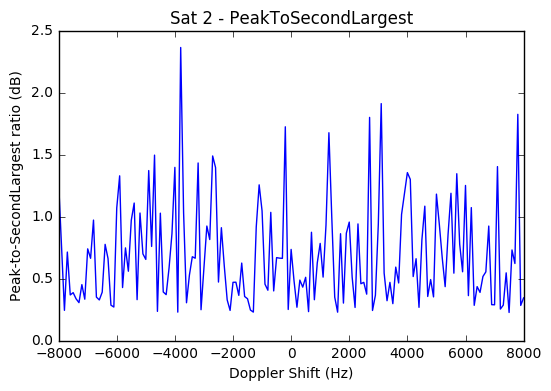

Sat: 2. Frequency with highest peak: -3800.000000
Sat: 3, Freq: -900.0000, PeakToMean:  17.5358, PeakToSecond:   7.3075, Phase (chips): 274.7500
Sat: 3, Freq: -700.0000, PeakToMean:  20.5876, PeakToSecond:  11.1969, Phase (chips): 274.7500
Sat: 3, Freq: -500.0000, PeakToMean:  26.3015, PeakToSecond:  18.7107, Phase (chips): 274.7500
Sat: 3, Freq: -400.0000, PeakToMean:  27.2234, PeakToSecond:  19.1176, Phase (chips): 274.7500
Sat: 3, Freq: -300.0000, PeakToMean:  25.8249, PeakToSecond:  17.6082, Phase (chips): 274.7500
Sat: 3, Freq: -100.0000, PeakToMean:  17.1938, PeakToSecond:   8.2747, Phase (chips): 274.7500


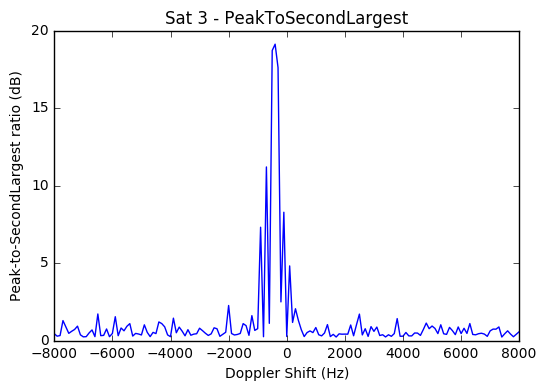

Sat: 3. Frequency with highest peak: -400.000000


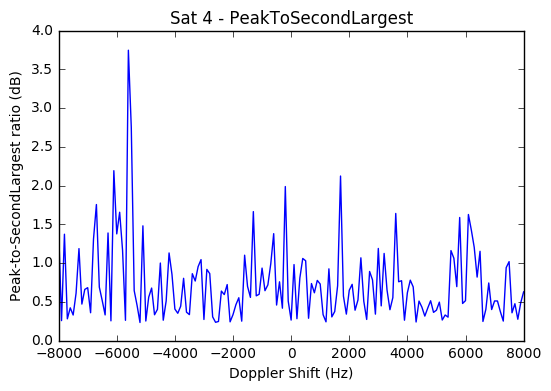

Sat: 4. Frequency with highest peak: -5600.000000


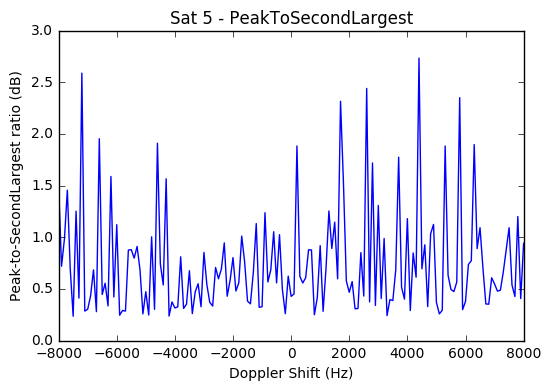

Sat: 5. Frequency with highest peak: 4400.000000
Sat: 6, Freq: -3500.0000, PeakToMean:  16.0759, PeakToSecond:   6.1957, Phase (chips): 630.0000
Sat: 6, Freq: -3300.0000, PeakToMean:  17.9857, PeakToSecond:   8.8943, Phase (chips): 630.0000
Sat: 6, Freq: -3200.0000, PeakToMean:  20.3054, PeakToSecond:  11.2951, Phase (chips): 630.0000


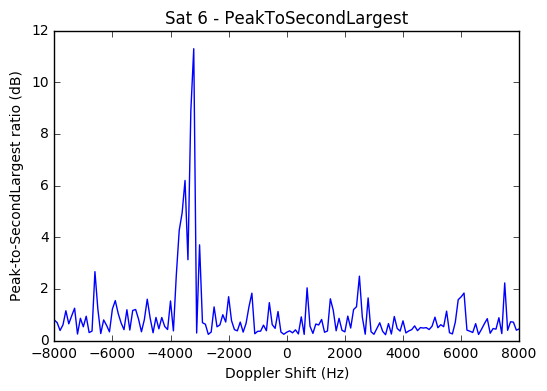

Sat: 6. Frequency with highest peak: -3200.000000
Sat: 7, Freq: 3300.0000, PeakToMean:  18.2448, PeakToSecond:   9.4899, Phase (chips): 652.5000
Sat: 7, Freq: 3400.0000, PeakToMean:  23.3838, PeakToSecond:  15.2223, Phase (chips): 652.5000
Sat: 7, Freq: 3500.0000, PeakToMean:  15.0579, PeakToSecond:   5.5558, Phase (chips): 652.5000


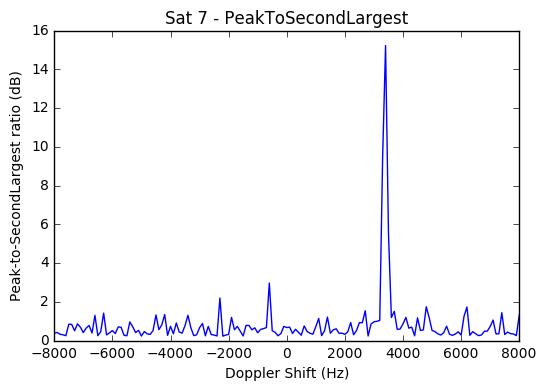

Sat: 7. Frequency with highest peak: 3400.000000


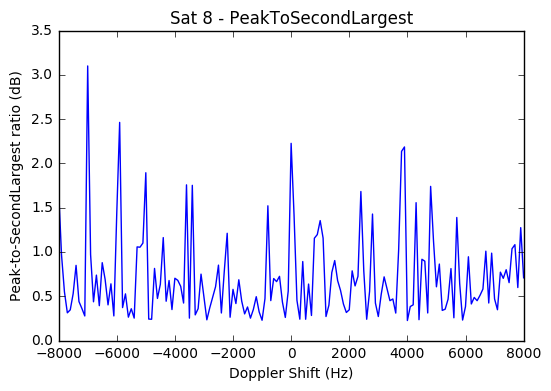

Sat: 8. Frequency with highest peak: -7000.000000
Sat: 9, Freq: 2700.0000, PeakToMean:  24.8093, PeakToSecond:  14.9765, Phase (chips): 490.7500
Sat: 9, Freq: 2800.0000, PeakToMean:  26.0090, PeakToSecond:  18.5074, Phase (chips): 490.7500
Sat: 9, Freq: 2900.0000, PeakToMean:  16.1530, PeakToSecond:   7.1862, Phase (chips): 490.7500


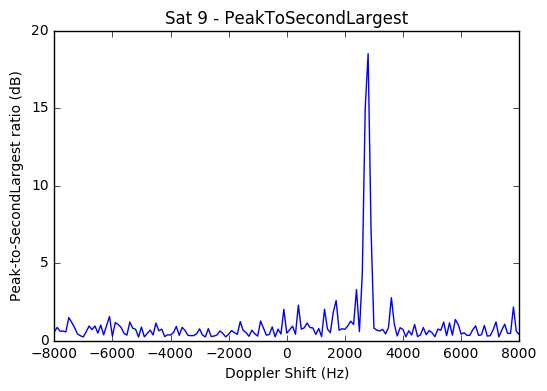

Sat: 9. Frequency with highest peak: 2800.000000


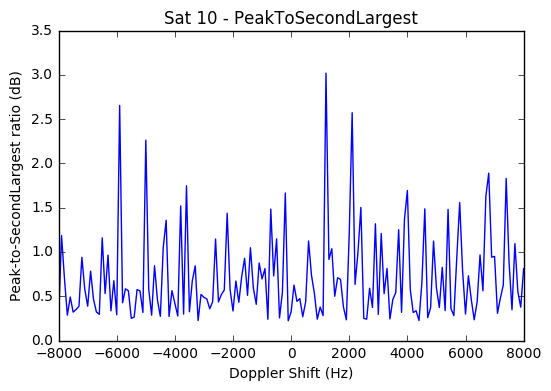

Sat: 10. Frequency with highest peak: 1200.000000


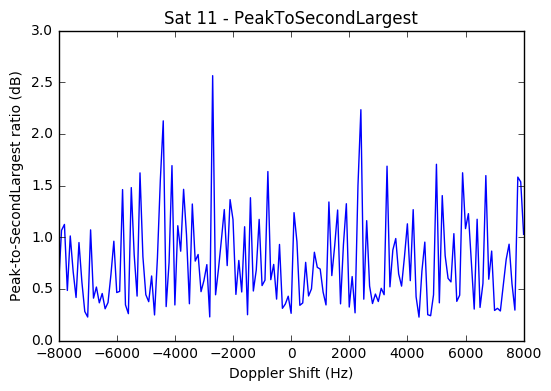

Sat: 11. Frequency with highest peak: -2700.000000


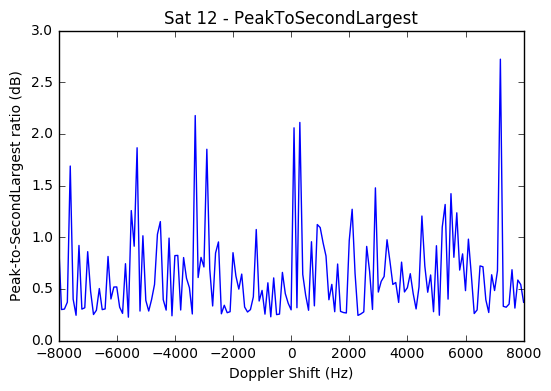

Sat: 12. Frequency with highest peak: 7200.000000


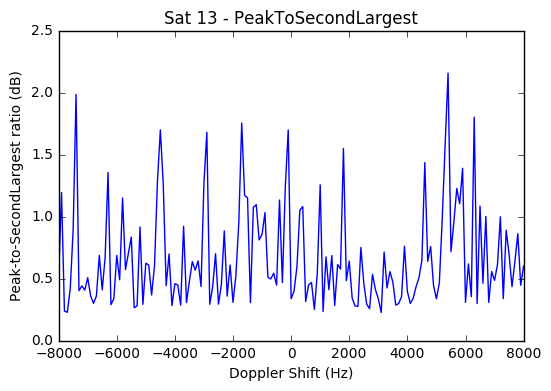

Sat: 13. Frequency with highest peak: 5400.000000


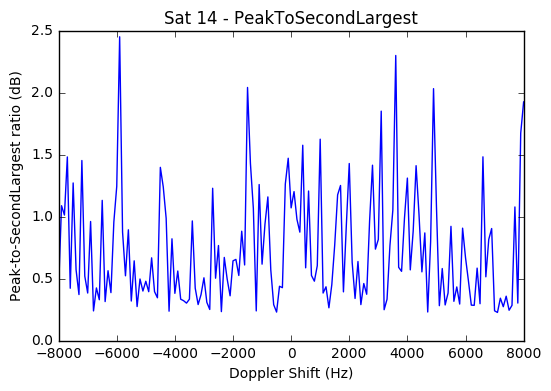

Sat: 14. Frequency with highest peak: -5900.000000


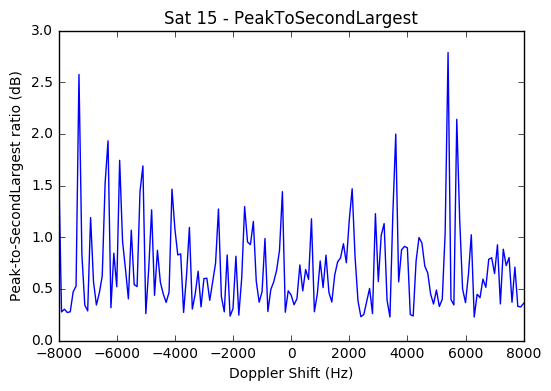

Sat: 15. Frequency with highest peak: 5400.000000
Sat: 16, Freq: 2800.0000, PeakToMean:  18.7855, PeakToSecond:   8.7125, Phase (chips):  34.2500
Sat: 16, Freq: 2900.0000, PeakToMean:  25.3166, PeakToSecond:  16.6141, Phase (chips):  34.2500
Sat: 16, Freq: 3000.0000, PeakToMean:  24.5206, PeakToSecond:  16.1272, Phase (chips):  34.2500
Sat: 16, Freq: 3100.0000, PeakToMean:  16.7503, PeakToSecond:   7.1067, Phase (chips):  34.2500


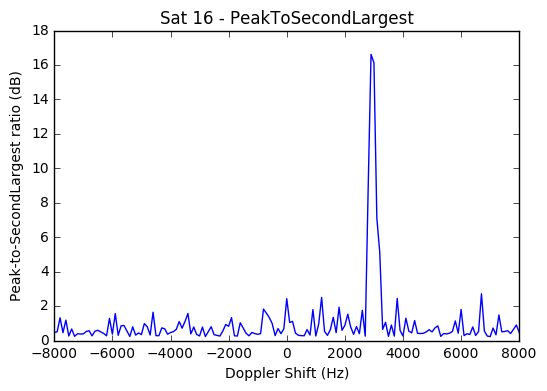

Sat: 16. Frequency with highest peak: 2900.000000


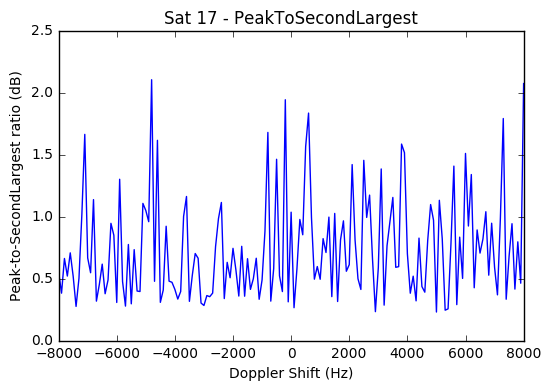

Sat: 17. Frequency with highest peak: -4800.000000


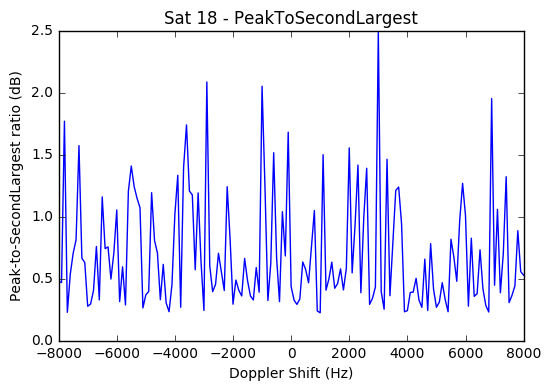

Sat: 18. Frequency with highest peak: 3000.000000


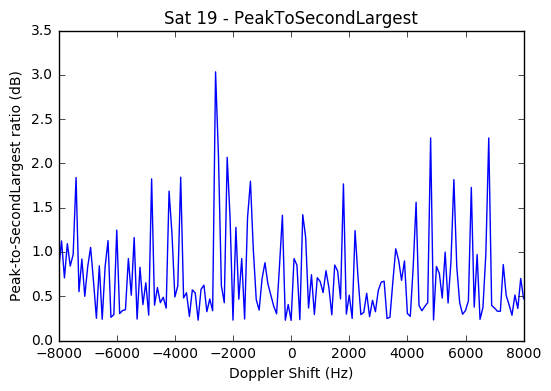

Sat: 19. Frequency with highest peak: -2600.000000


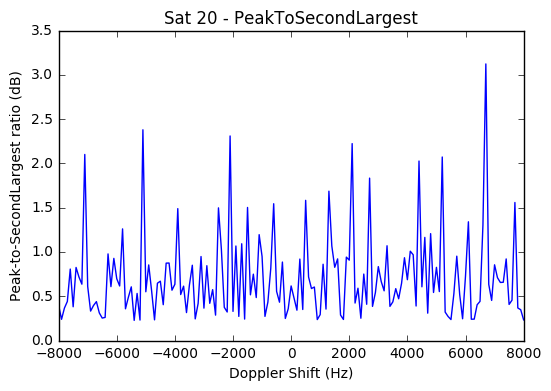

Sat: 20. Frequency with highest peak: 6700.000000


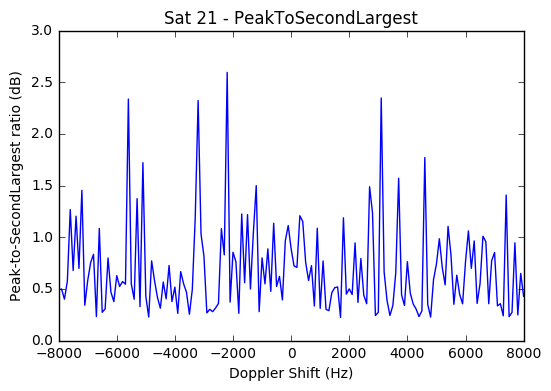

Sat: 21. Frequency with highest peak: -2200.000000


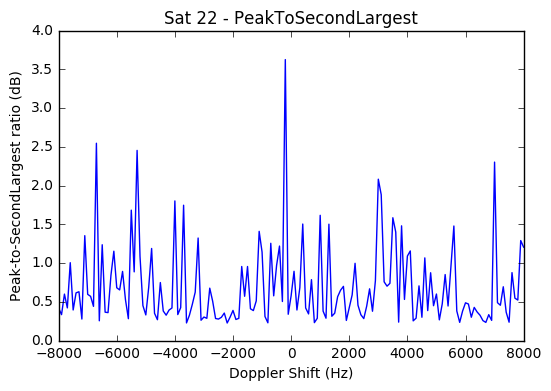

Sat: 22. Frequency with highest peak: -200.000000
Sat: 23, Freq: 1300.0000, PeakToMean:  17.5596, PeakToSecond:   8.5511, Phase (chips): 617.7500
Sat: 23, Freq: 1400.0000, PeakToMean:  20.6138, PeakToSecond:  11.0941, Phase (chips): 617.7500
Sat: 23, Freq: 1500.0000, PeakToMean:  26.1194, PeakToSecond:  16.7855, Phase (chips): 617.7500
Sat: 23, Freq: 1600.0000, PeakToMean:  25.6271, PeakToSecond:  15.6578, Phase (chips): 617.7500
Sat: 23, Freq: 1700.0000, PeakToMean:  21.4870, PeakToSecond:  11.7096, Phase (chips): 617.7500
Sat: 23, Freq: 1800.0000, PeakToMean:  15.6453, PeakToSecond:   5.9959, Phase (chips): 617.7500


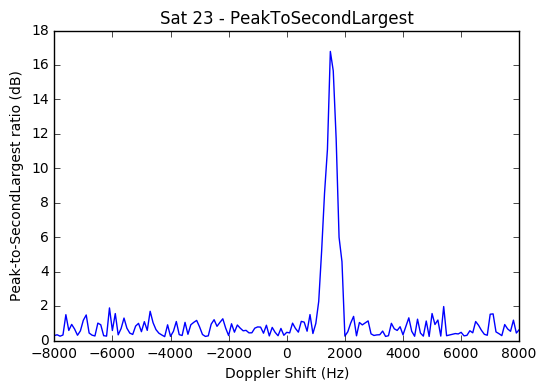

Sat: 23. Frequency with highest peak: 1500.000000


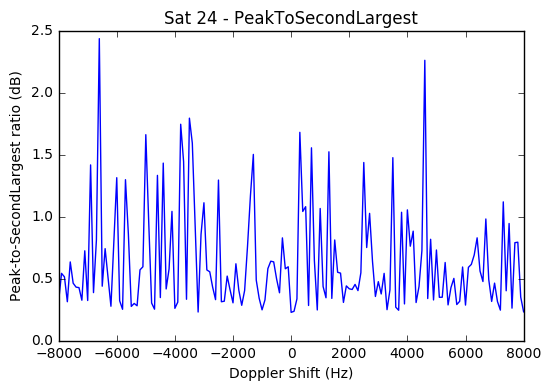

Sat: 24. Frequency with highest peak: -6600.000000


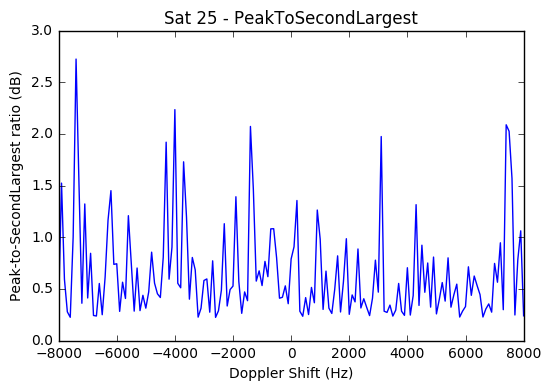

Sat: 25. Frequency with highest peak: -7400.000000
Sat: 26, Freq: 800.0000, PeakToMean:  15.6471, PeakToSecond:   6.9444, Phase (chips): 808.7500
Sat: 26, Freq: 900.0000, PeakToMean:  17.5380, PeakToSecond:   8.7141, Phase (chips): 808.7500
Sat: 26, Freq: 1000.0000, PeakToMean:  25.1214, PeakToSecond:  17.2558, Phase (chips): 808.7500
Sat: 26, Freq: 1100.0000, PeakToMean:  26.6084, PeakToSecond:  18.1168, Phase (chips): 808.7500
Sat: 26, Freq: 1200.0000, PeakToMean:  19.9402, PeakToSecond:  11.7350, Phase (chips): 808.7500


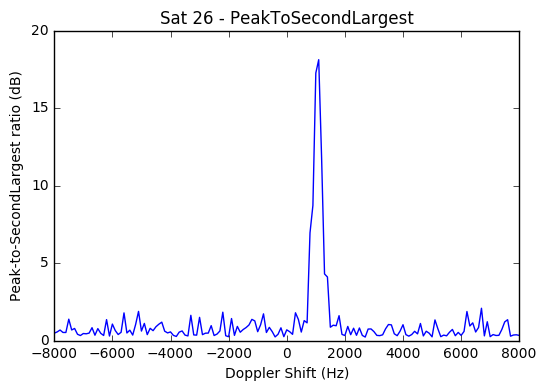

Sat: 26. Frequency with highest peak: 1100.000000


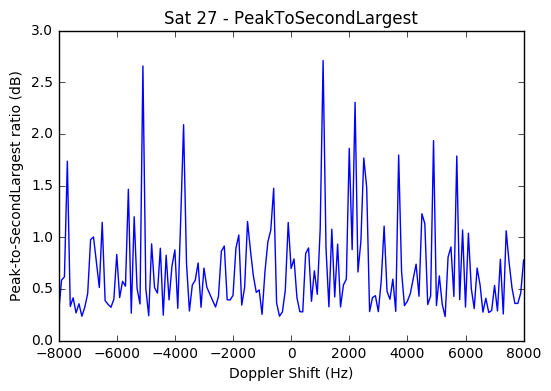

Sat: 27. Frequency with highest peak: 1100.000000


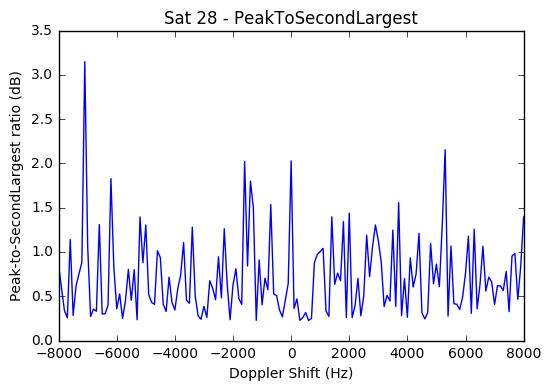

Sat: 28. Frequency with highest peak: -7100.000000


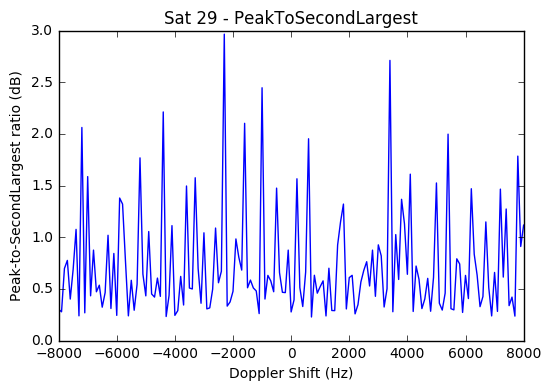

Sat: 29. Frequency with highest peak: -2300.000000


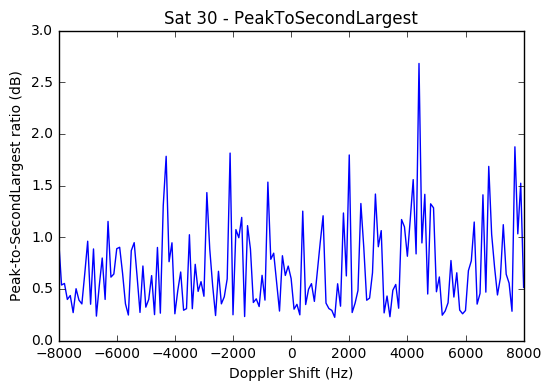

Sat: 30. Frequency with highest peak: 4400.000000
Sat: 31, Freq: -3200.0000, PeakToMean:  22.0031, PeakToSecond:  12.2823, Phase (chips): 280.0000
Sat: 31, Freq: -3100.0000, PeakToMean:  25.8418, PeakToSecond:  17.1458, Phase (chips): 280.0000
Sat: 31, Freq: -3000.0000, PeakToMean:  23.7966, PeakToSecond:  14.7425, Phase (chips): 280.0000
Sat: 31, Freq: -2800.0000, PeakToMean:  16.3920, PeakToSecond:   7.0240, Phase (chips): 280.0000


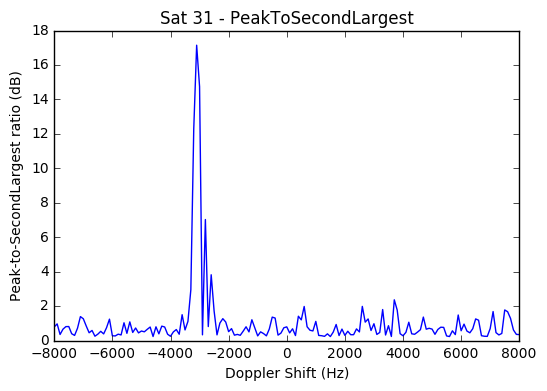

Sat: 31. Frequency with highest peak: -3100.000000
Sat: 32, Freq: -2900.0000, PeakToMean:  19.9721, PeakToSecond:  10.7875, Phase (chips): 289.5000
Sat: 32, Freq: -2800.0000, PeakToMean:  27.4665, PeakToSecond:  19.4724, Phase (chips): 289.5000
Sat: 32, Freq: -2700.0000, PeakToMean:  26.6589, PeakToSecond:  18.8481, Phase (chips): 289.5000
Sat: 32, Freq: -2600.0000, PeakToMean:  18.3158, PeakToSecond:   9.1500, Phase (chips): 289.5000


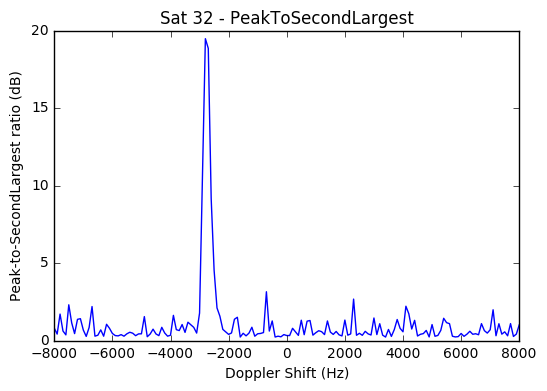

Sat: 32. Frequency with highest peak: -2800.000000


In [13]:
# Choose what frequencies and satellites to increment over
StartingFrequencyShift = -8*10**3
EndingFrequencyShift = 8*10**3
FrequencyShiftIncrement = 100
FrequencyList = range(StartingFrequencyShift,EndingFrequencyShift + FrequencyShiftIncrement,FrequencyShiftIncrement)

StartingSatellite = 1
EndingSatellite = 32
SatelliteList = range(StartingSatellite, EndingSatellite + 1)

# Create list of C/A code Taps, for simpler sat selection",
#sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

# Create array to store max values, freq ranges, per satellite
class SatStats():
    def __init__(self, SatName):
        self.SatName = SatName
        self.dBPeakToMean = []
        self.PeakToSecond = []
SatInfo = []        
#SatMax = np.zeros((len(SatelliteList),len(FrequencyList),4))

satInd = 0 
# Loop through selected satellites
for curSat in SatelliteList: 
    # Create Code Generator object for chosen Satellite
    CodeGen = GoldCode(sat[curSat - 1]) # Index starts at zero
    
    # Generate CA Code
    CACode = CodeGen.getCode(1023)
    
    # Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
    CACodeSampled = np.repeat(CACode,4)
    
    # Repeat entire array for each ms of data sampled
    CACodeSampled = np.tile(CACodeSampled,NumberOfMilliseconds)
    Codefft = np.fft.fft(CACodeSampled,nfft)
    GCConj = np.conjugate(Codefft)
    
    SatInfo.append(SatStats(curSat))
    freqInd = 0
    # Loop through all frequencies
    for curFreq in FrequencyList:
        # Initialize complex array
        CDataShifted = np.zeros(len(data.CData), dtype=np.complex)
        
        # Shift frequency using complex exponential 
        CDataShifted = data.CData*np.exp(-1j*2*np.pi*curFreq*data.t)

        fftCDataShifted = np.fft.fft(CDataShifted,nfft)
        
        result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
        
        resultSQ = np.real(result*np.conjugate(result))
        
        rmsPowerdB = 10*np.log10(np.mean(resultSQ))
        resultdB= 10*np.log10(resultSQ)
    
        maxAbsSquared = np.amax(resultSQ)
        maxAbsSquaredInd = np.argmax(resultSQ)
        phaseInTime = maxAbsSquaredInd/fs
        phaseInChips = phaseInTime*1.023*10**6
        phaseInChips = 1023 - phaseInChips%1023
        
        maxdB = np.amax(resultdB)
        maxdBInd = np.argmax(resultdB)
        
        PeakTodBRatio = maxdB - rmsPowerdB
        
        # Search for secondlargest value in 1 ms worth of data
        SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

        # Pseudo SNR
        PeakToSecondLargestRatio = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
        
        SatInfo[satInd].dBPeakToMean.append(PeakTodBRatio)
        SatInfo[satInd].PeakToSecond.append(PeakToSecondLargestRatio)
        
        # Don't print data when correlation is probably not happening
        if PeakToSecondLargestRatio > 5.5:
            print("Sat: %d, Freq: %8.4f, PeakToMean: %8.4f, PeakToSecond: %8.4f, Phase (chips): %8.4f" 
                  %(curSat,curFreq,PeakTodBRatio,PeakToSecondLargestRatio, phaseInChips))

        freqInd = freqInd + 1
        

    ''' Peak to Mean doesn't show as much
    plt.figure()
    plt.plot(FrequencyList, SatInfo[satInd].dBPeakToMean)
    #plt.ylim((0,20))
    plt.xlabel('Doppler Shift (Hz)')
    plt.ylabel('Peak-to-RMS ratio (dB)')
    plt.title("Sat %d - PeakToRMS"%curSat)
    plt.show()
    '''
    
    plt.figure()
    plt.plot(FrequencyList, SatInfo[satInd].PeakToSecond)
    #plt.ylim((0,20))
    plt.xlabel('Doppler Shift (Hz)')
    plt.ylabel('Peak-to-SecondLargest ratio (dB)')
    plt.title("Sat %d - PeakToSecondLargest"%curSat)
    plt.show()
    
    MaxFreqThisSat = FrequencyList[np.argmax(SatInfo[satInd].PeakToSecond)]
    print("Sat: %d. Frequency with highest peak: %f" %(curSat,MaxFreqThisSat))
    
    satInd = satInd+1

For this data sample (Launch 12, 4 seconds after launch) we should see the following satellites:

Sat | S/N (dB-Hz) | doppler shift (Hz) | code phase (chips)
:----- | -------:| -------:| --------:
 1 | 13.287713  | -1209.276720 | 394.250000
 4 | 13.700614 | 600.950356 | 547.750000
 11 | 13.381992 | 612.980296 | 514.750000
 13 | 13.554054 | -12.064141 | 655.250000
 15 | 15.276798 | -1399.910091 | 489.750000
 
 So if we generate the Gold codes for the correct satellites and correct for the Doppler shift, we should see a peak in the time domain correlator.


# Generate Gold Code for selected satellite

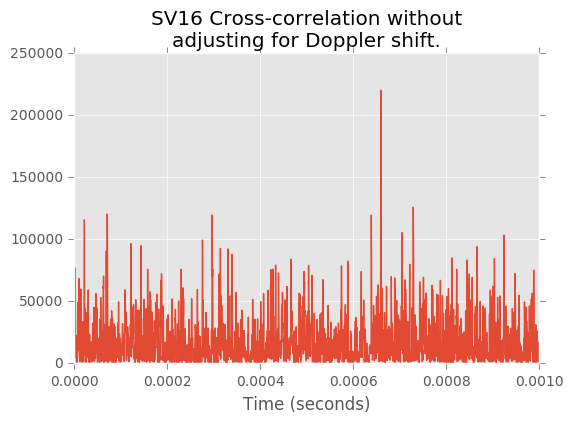

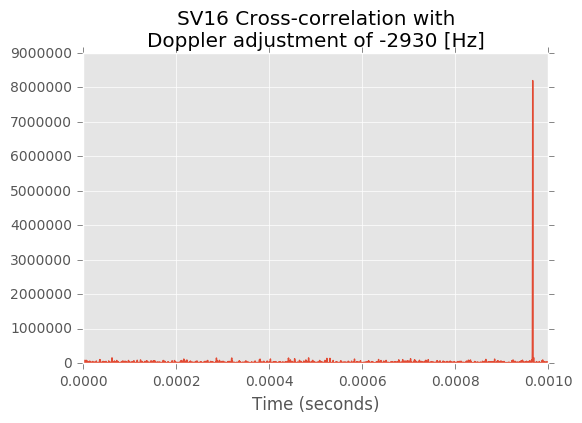

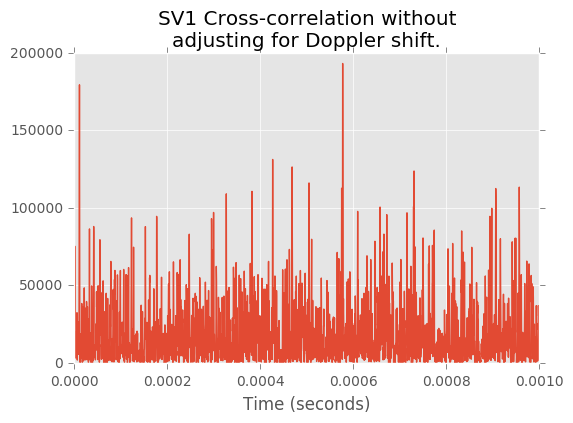

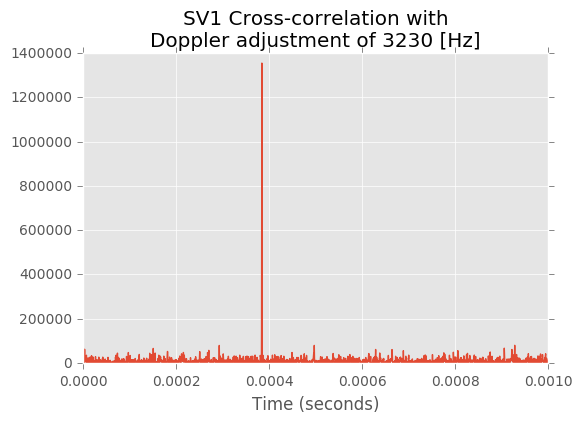

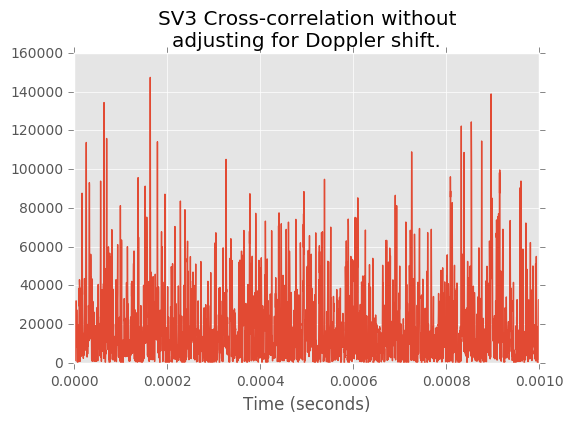

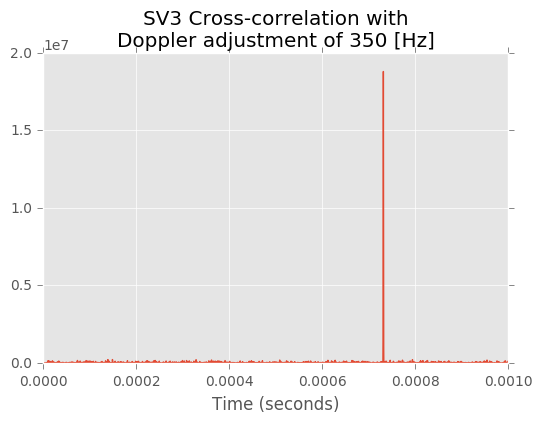

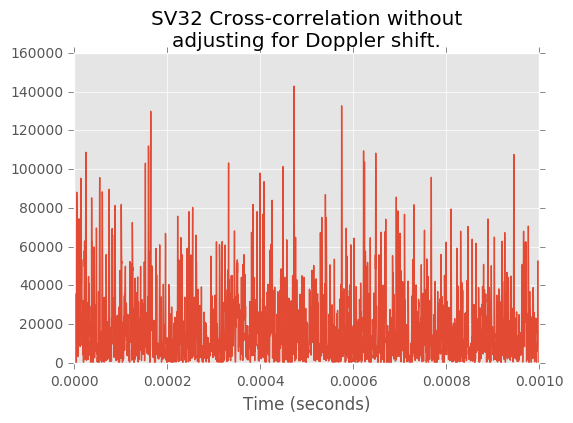

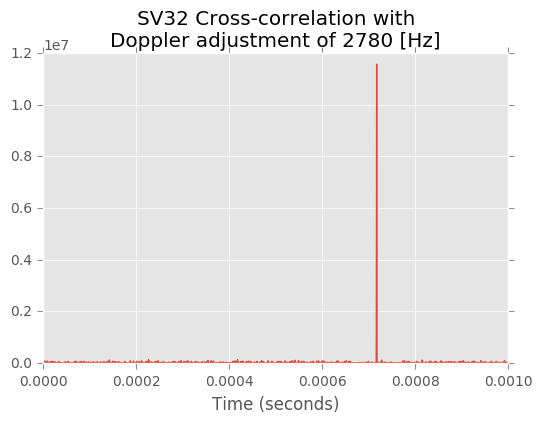

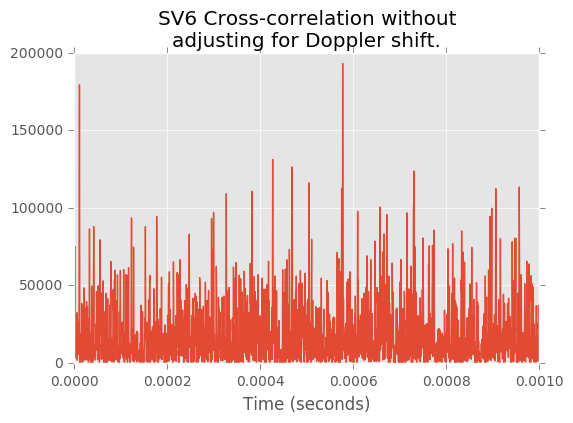

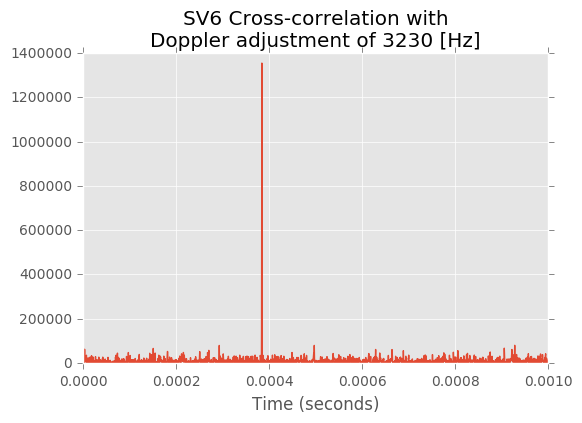

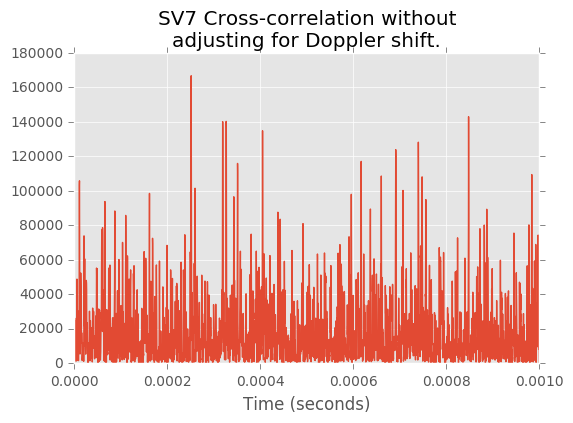

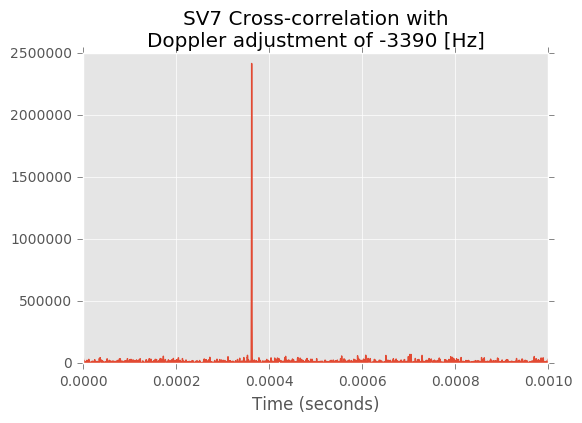

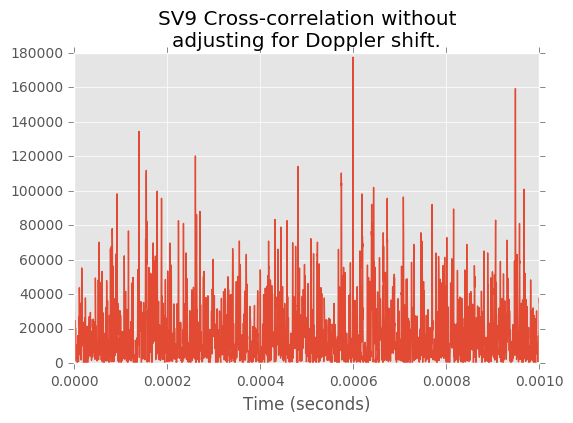

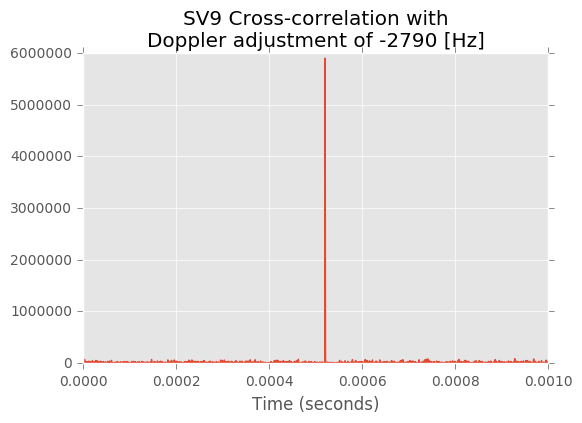

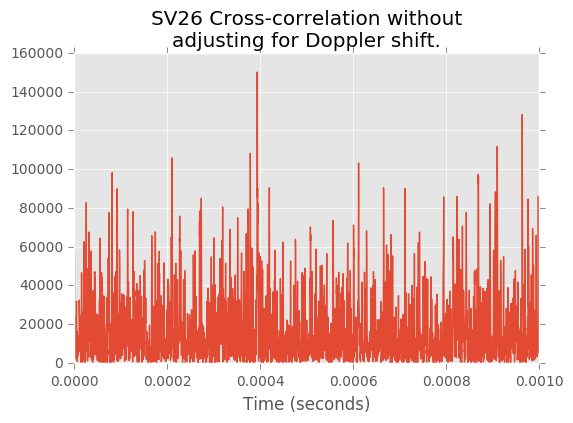

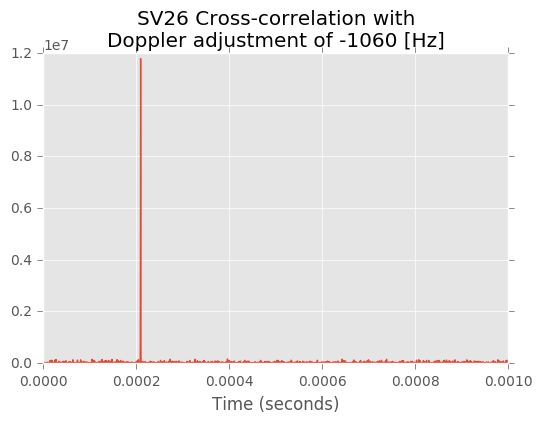

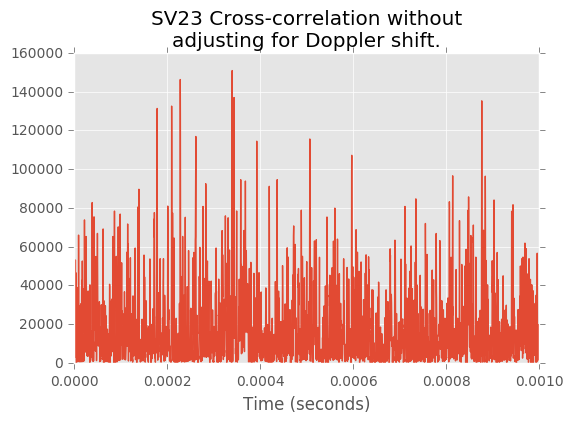

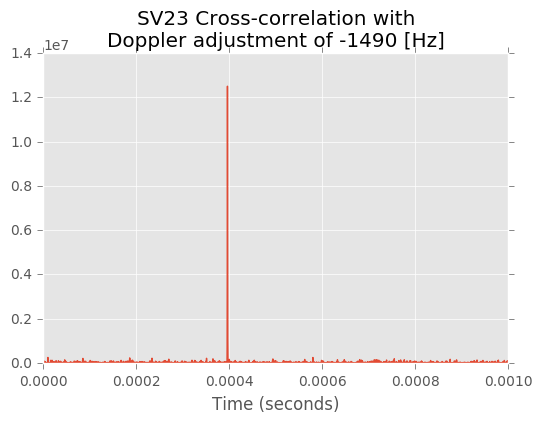

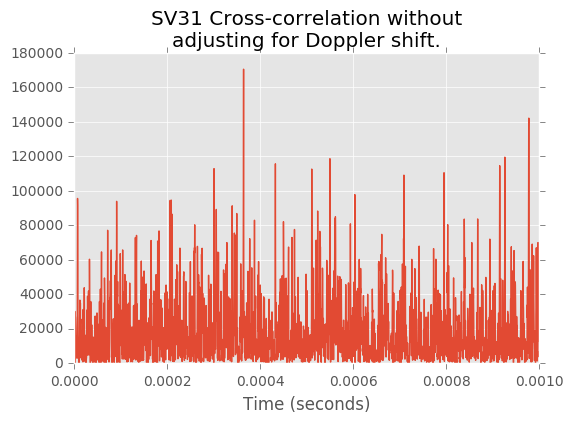

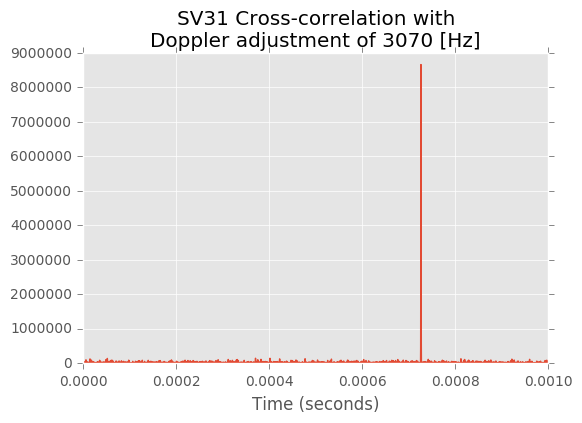

In [14]:
# Uncomment for Launch12 Data (JGPS@04.559925043) :
#sats = {1: -1209.3, 4: 600.95, 11: 612.98, 13: -12.06, 15: -1399.9}

# Uncomment for gps-sdr-sim generated data (test.max)
sats = {1: -3230, 3: -350, 6: -3230, 7: 3390, 9:2790, 16: 2930, 23: 1490, 26: 1060, 31: -3070, 32: -2780 }

plt.style.use('ggplot')

for Satellite, Doppler in sats.items():

    #code = np.repeat(CodeGen.getCode(1023), 4)

    # Create Code Generator object for chosen Satellite
    CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

    # Generate CA Code
    CACode = CodeGen.getCode(1023)

    # Reformat GC to have -1 in place of 0 (Now done in GoldCode)
    #for n,i in enumerate(CACode):
    #    if i==0:
    #        CACode[n]=-1

    # Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
    CACodeSampled = np.repeat(CACode,4)

    # Repeat entire array for each ms of data sampled
    CACodeSampled = np.tile(CACodeSampled,int(SampleLength*1000))
 
    Codefft = np.fft.fft(CACodeSampled)
    GCConj = np.conjugate(Codefft)
    

    result = np.fft.ifft(GCConj * ffC,nfft)

    resultSQ = np.real(result*np.conjugate(result))

    t = np.linspace(0,SampleLength,nfft,endpoint=True) 
#    plt.figure(figsize=(10,6))
    
    plt.plot(t,resultSQ)

    # Zoom in to one ms
    xmin,xmax = plt.xlim()
    plt.xlim(xmin,xmin + 0.001)


    plt.title("SV%d Cross-correlation without\nadjusting for Doppler shift."%Satellite)
    plt.xlabel("Time (seconds)")
    plt.show()

    # Search for largest value in 1 ms worth of data
    SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

    # Pseudo SNR
    ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
    
    freqShift = -Doppler #[Hz] -20


    # Initialize complex array
    CDataShifted = data.CData*np.exp(1j*2*np.pi*freqShift*data.t)
    fftCDataShifted = np.fft.fft(CDataShifted,nfft)

    result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
    resultSQ = np.real(result*np.conjugate(result))
    resultLog = 10*np.log10(resultSQ)

 #   plt.figure(figsize=(10,6))
    plt.plot(t,resultSQ)
    plt.title("SV%d Cross-correlation with\nDoppler adjustment of %d [Hz]"%(Satellite, freqShift))
    plt.xlabel("Time (seconds)")

    # Zoom in to one ms
    xmin,xmax = plt.xlim()
    plt.xlim(xmin,xmin + 0.001)
    plt.show()

    # Search for largest value in 1 ms worth of data
    SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

    # Pseudo SNR
    ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)


In [15]:
maxAbsSquared

166591.6273300953

In [16]:
secondMax

NameError: name 'secondMax' is not defined

In [ ]:
resultSQ

In [ ]:
plt.plot(resultSQ)
plt.show()